# Description of the mini-project

## Dataset

In this mini-project we will work with a dataset used in the *EE-490 Lab in Data Science* course. It is composed of CO2 measurements taken from a pool of 46 cheap but inaccurate sensors deployed in the city of Zurich. In addition, we also have access to temperature and humidity measurements, the altitude of the sensor as well as the average daily wind pattern for the city.

## Prior Knowledge

Measurements highly depends on the temperature, the humidity, the wind, the altitude and the level of traffic around the site. For example, a sensor that is located in a mountain with high altitude and exposed to strong winds is expected to have a much lower and uniform level of CO2 compared to another sensor that is located near the center of the city and close to a busy industrial zone exposed to high traffic activity. We also know that there is a strong dependence of the CO2 measurements on the temperature and the humidity.

## Assumption

Sensors in similar conditions are expected to have similar measurements.

## Issue

It might be the case that one sensor suddenly begins to take wrong measurements. The detection of faulty sensors is done by an external domain expert. Then, our job consists in curate the CO2 measurements for that particular sensor through our regression model.

## Goal

Fit a linear regression model to the CO2 measurements based on the aforementioned features. Do a performance evaluation between several models by comparing the fitting time and the goodness of fit.

## Proposed solution and structure

Our proposed solution can be decomposed in the following parts:

* Preprocessing: features come in different files, we need to aggregate them and make sure the data comes exempt from missing values or any defect. K-means is used to optimally group sensor that are in similar conditions, such as altitude and wind exposure.
* Faulty sensor modeling: in order to test our model's ability to fit the lost measurements, we need to model the faulty sensors. In this way we will be able to compare our prediction against the true measurements.
* Performance evaluation: compare the different models and select the most appropriate one.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [10]:
import pandas as pd
from tqdm import tqdm_notebook as tqdm

from functions import *

## Preprocessing

### Merging CO2 measurements, temperature and humidity in a single dataframe.

In [11]:
# Load the data
CO2_measurement = pd.read_csv('data/CO2_sensor_measurements.csv', sep='\t')
zurich_average_wind = pd.read_csv('data/zurich_average_wind.csv', sep='\t')
zurich_temp_humidity= pd.read_csv('data/temperature_humidity.csv', sep='\t')
sensors_metadata = pd.read_csv('data/sensors_metadata.csv', sep='\t') 

# Some values are missing, that is why we will interpolate them by taking the average over an interval of 30min.
# We will also aggregate all the information of CO2 measurements, temperature and humidity into one single 
# dataframe for more practicality.

# interpolate CO2_measurement
CO2_measurement = CO2_measurement.interpolate().set_index('timestamp')
CO2_measurement.index = pd.to_datetime(CO2_measurement.index)
grouper = CO2_measurement.groupby([pd.Grouper(freq='30Min'), 'LocationName', 'SensorUnit_ID'])
grouper = grouper.mean()


# interpolate temperature and humidity
zurich_temp_humidity = zurich_temp_humidity.interpolate().set_index('Timestamp')
zurich_temp_humidity.index.names = ['timestamp']
zurich_temp_humidity.index = pd.to_datetime(zurich_temp_humidity.index)
zurich_temp_humidity = zurich_temp_humidity.resample('30Min').mean()

# merge the two dataframes
grouper = grouper.reset_index()
mth = pd.DataFrame()
for e in tqdm(zurich_temp_humidity.columns[::2]):
    id_ = int(e.split('.')[0])
    df = zurich_temp_humidity[['{}.temperature'.format(id_), '{}.humidity'.format(id_)]].rename(
        columns={
            '{}.temperature'.format(id_): 'temperature',
            '{}.humidity'.format(id_):'humidity'
        }
    )
    df['SensorUnit_ID'] = id_
    mth = mth.append(grouper.merge(df.reset_index(), on=['timestamp', 'SensorUnit_ID'])) 
mth = mth.set_index('timestamp')

In [12]:
mth.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity
timestamp,,,,,
2017-10-01 00:00:00,ZGHD,1014,595.004391,11.396667,92.440806
2017-10-01 00:30:00,ZGHD,1014,597.017879,11.303333,91.625097
2017-10-01 01:00:00,ZGHD,1014,596.487010,11.240000,91.096761
2017-10-01 01:30:00,ZGHD,1014,598.787639,11.260000,91.275734
2017-10-01 02:00:00,ZGHD,1014,595.366394,11.285000,91.003937


### Applying K-means for the altitude and wind exposure.

For the altitude: K-means will be computed based on two features of the sensor. Its altitude and its median of the CO2 measurements for the entire month.

In [13]:
# take the median of the CO2_measurements
CO2_measurements = mth[['LocationName', 'CO2']].groupby([pd.Grouper(freq='1M'), 'LocationName'])\
                    .median().reset_index().drop('timestamp', 1).set_index('LocationName')

# select only altitude from the metadata
altitude = sensors_metadata[['LocationName', 'altitude']].set_index('LocationName')

# join both features in a single dataframe
ma = CO2_measurements.join(altitude)
ma.rename(columns={'CO2': 'median CO2'}, inplace=True)
ma.head()

,median CO2,altitude
LocationName,,
AJGR,334.785793,627.8
BSCR,475.316233,462.3
BUDF,422.793126,490.2
KBRL,410.100150,510.5
KTGM,444.395518,530.3


#### Determine the correct value of k

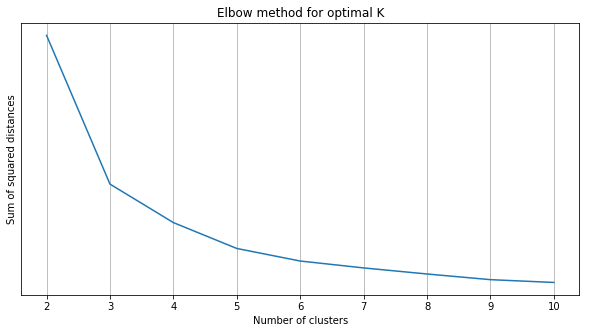

In [14]:
plot_elbow_method(ma[['median CO2', 'altitude']])

In [11]:
"""X = ma.values
range_k = range(2,11)
for k in range_k:
    cluster = KMeans(n_clusters=k)
    cluster_labels = cluster.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print('For K={}, the average silhouette score is {:1.5f}.'.format(k, silhouette_avg))"""

"X = ma.values\nrange_k = range(2,11)\nfor k in range_k:\n    cluster = KMeans(n_clusters=k)\n    cluster_labels = cluster.fit_predict(X)\n    silhouette_avg = silhouette_score(X, cluster_labels)\n    print('For K={}, the average silhouette score is {:1.5f}.'.format(k, silhouette_avg))"

In [12]:
ma['altitude_cluster'] = KMeans(K_cluster_altitude).fit(ma[['median CO2', 'altitude']]).labels_
ma.head()

,median CO2,altitude,altitude_cluster
LocationName,,,
AJGR,334.785793,627.8,9
BSCR,475.316233,462.3,7
BUDF,422.793126,490.2,4
KBRL,410.100150,510.5,4
KTGM,444.395518,530.3,4


In [13]:
# merge the in to current dataframe
mth = mth.reset_index().merge(ma.reset_index(), on='LocationName').set_index('timestamp')
mth.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity,median CO2,altitude,altitude_cluster
timestamp,,,,,,,,
2017-10-01 00:00:00,ZGHD,1014,595.004391,11.396667,92.440806,614.578185,413.5,6
2017-10-01 00:30:00,ZGHD,1014,597.017879,11.303333,91.625097,614.578185,413.5,6
2017-10-01 01:00:00,ZGHD,1014,596.487010,11.240000,91.096761,614.578185,413.5,6
2017-10-01 01:30:00,ZGHD,1014,598.787639,11.260000,91.275734,614.578185,413.5,6
2017-10-01 02:00:00,ZGHD,1014,595.366394,11.285000,91.003937,614.578185,413.5,6


For the wind exposure: we will perform a Principle Component Analysis (PCA) to reduce the dimension to 2 (instead of 48) for a single and perform a daily clustering based on these PCA coefficients.

In [14]:
# load the dataframe
ZU_aw = zurich_average_wind.copy()
ZU_aw.set_index('timestamp', inplace=True)
ZU_aw.index = pd.to_datetime(ZU_aw.index)
ZU_aw.head()

# reorganize structure to perform dimension reduction
daily_sample = pd.DataFrame(columns=list(range(48)))
for index, row in ZU_aw.groupby(ZU_aw.index.day):
    day = row.index[0].date()
    daily_sample.loc[day] = row.values.T[0]

# apply PCA decomposition
pca = decomposition.PCA(n_components=2)
pca_components = pd.DataFrame(columns=['component_1', 'component_2'], index=daily_sample.index)
components_values = pca.fit_transform(daily_sample.values)
pca_components.loc[:] = components_values
pca_components.index.names = ['timestamp']
pca_components.head()

,component_1,component_2
timestamp,,
2017-10-01,-4.106523,-1.663550
2017-10-02,-0.869377,4.207631
2017-10-03,8.023951,-8.309913
2017-10-04,-3.281485,-0.074907
2017-10-05,8.288445,11.560985


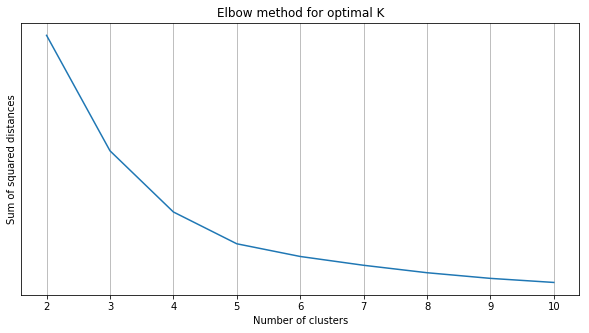

In [15]:
plot_elbow_method(pca_components[['component_1', 'component_2']])

In [16]:
pca_components['wind_cluster'] = KMeans(K_cluster_wind).fit(pca_components[['component_1', 'component_2']]).labels_
pca_components.head()

,component_1,component_2,wind_cluster
timestamp,,,
2017-10-01,-4.106523,-1.663550,1
2017-10-02,-0.869377,4.207631,7
2017-10-03,8.023951,-8.309913,2
2017-10-04,-3.281485,-0.074907,7
2017-10-05,8.288445,11.560985,4


## Faulty sensor modeling

Despite a request to the teaching staff for information about how to properly model a faulty sensor, no useful details have been provided to us as they were mainly guided by the domain experts. Thus, the only behaviour from which we can draw inspiration from is that of the sensor `ZSBN`. In addition, we know that the change occurs after October 24th. The figure below shows the results obtained from the past homework.

![caption](figures/zsbn_sensor.png)

Although this would require further investigation, we choose a simplistic approach: we will model a faulty sensor as one that undergoes a drift (up or down) and a rescale in amplitude. 

### Create faulty sensors

We will generate faulty sensor from three of them: `AJGR`, `BSCR`, `BUDF`. We will also set the date of failure from the 24th of October. The main reason is that we will only lost about 25% of the data and the remaining 75% of the data will be used for training. We think that the percentage of training data plays a big role in the accuracy of the prediction.

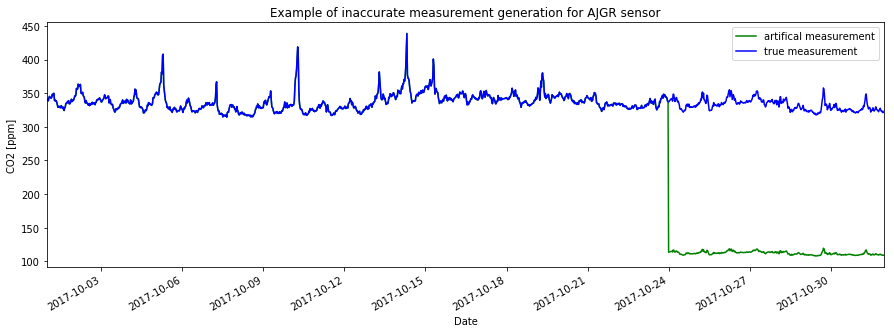

In [19]:
df_mth = mth.copy()
faulty_sensors = ['AJGR', 'BSCR', 'ZSTA', 'ZUE', 'ZSBN', 'ZLMT']
generate_faulty_sensors(df_mth, faulty_sensors)
plot_faulty_sensor(df_mth, 'AJGR')

## Information criterion


In [20]:
aic = {}

## Performance Evaluation

### 1) Naive Approach with different methods implemented. These methods can be tweaked to get the best results
Rely solely on the faulty sensor.

In [21]:
df_mth.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity,median CO2,altitude,altitude_cluster,groundtruth
timestamp,,,,,,,,,
2017-10-01 00:00:00,ZGHD,1014,595.004391,11.396667,92.440806,614.578185,413.5,6,NaN
2017-10-01 00:30:00,ZGHD,1014,597.017879,11.303333,91.625097,614.578185,413.5,6,NaN
2017-10-01 01:00:00,ZGHD,1014,596.487010,11.240000,91.096761,614.578185,413.5,6,NaN
2017-10-01 01:30:00,ZGHD,1014,598.787639,11.260000,91.275734,614.578185,413.5,6,NaN
2017-10-01 02:00:00,ZGHD,1014,595.366394,11.285000,91.003937,614.578185,413.5,6,NaN


In [24]:
naive_regression(df_mth, faulty_sensors)

In [25]:
df_mth[(df_mth['LocationName'] == 'AJGR') & (df_mth.index.day >=24)].head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity,median CO2,altitude,altitude_cluster,groundtruth,naive_Ridge_prediction,naive_Lasso_prediction,naive_ElasticNet_prediction,naive_LinearRegression_prediction,naive_LinearRegression_lower_bound,naive_LinearRegression_upper_bound
timestamp,,,,,,,,,,,,,,,
2017-10-24 00:00:00,AJGR,1122,113.574027,6.753333,95.641973,334.785793,627.8,9,336.915833,341.156826,341.254125,341.261943,341.156703,323.762492,369.357423
2017-10-24 00:30:00,AJGR,1122,113.893428,6.850000,94.735664,334.785793,627.8,9,338.020819,340.730043,340.861304,340.866543,340.729889,324.124535,366.930001
2017-10-24 01:00:00,AJGR,1122,114.144441,6.900000,94.317319,334.785793,627.8,9,338.889211,340.539332,340.685222,340.689329,340.539165,322.860177,368.082537
2017-10-24 01:30:00,AJGR,1122,114.620098,6.843333,94.334167,334.785793,627.8,9,340.534774,340.483126,340.639064,340.642624,340.482949,322.810265,364.306457
2017-10-24 02:00:00,AJGR,1122,114.702936,6.700000,94.568136,334.785793,627.8,9,340.821359,340.454923,340.625136,340.628078,340.454733,323.375389,369.971505


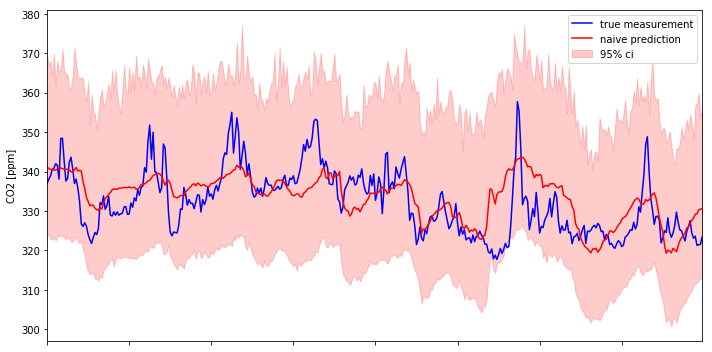

In [108]:
plot_zoomed_prediction(df_complete, 'AJGR', 'naive', 'LinearRegression', 'AJGR_naive', ci=True)

Text(0,0.5,'Component 2')

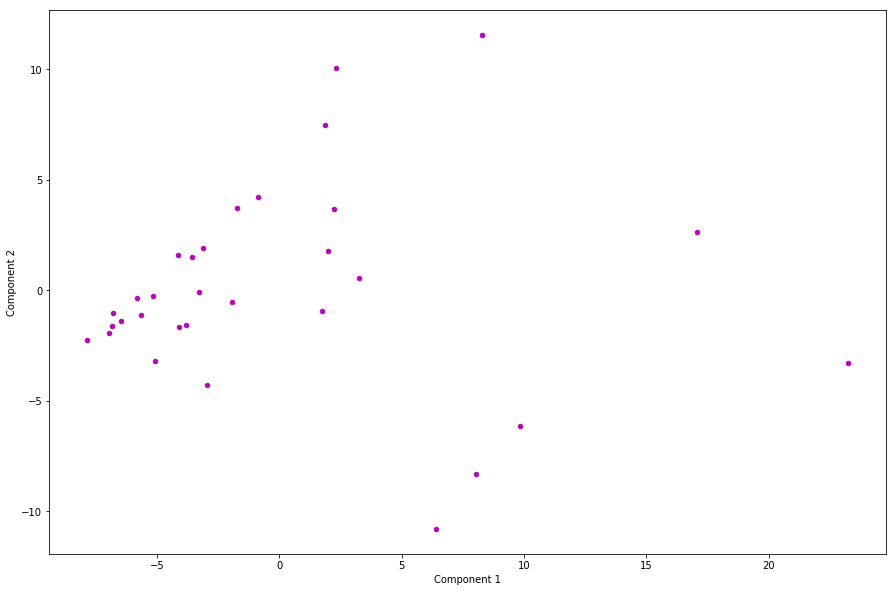

In [27]:
fig, ax = plt.subplots(figsize=(15,10))
ax.patch.set_alpha(0)
fig.patch.set_alpha(0)
pca_components.plot(x='component_1', y='component_2', kind='scatter', color='m', ax=ax)

#plt.title('Sensor visualisation based on altitude and median CO2 measurement')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

In [65]:
"""regs = ['LinearRegression','Lasso', 'Ridge', 'ElasticNet']
sensor = 'AJGR'
approach = 'naive'
for reg in regs:
    plot_prediction(df_mth, sensor, approach, reg)
    plot_zoomed_prediction(df_mth, sensor, approach, reg)"""

"regs = ['LinearRegression','Lasso', 'Ridge', 'ElasticNet']\nsensor = 'AJGR'\napproach = 'naive'\nfor reg in regs:\n    plot_prediction(df_mth, sensor, approach, reg)\n    plot_zoomed_prediction(df_mth, sensor, approach, reg)"

### 2) Add zone and altitude information (za) with other techniques (ridge, elastic net, lasso)
We will now make use of the zone of the sensor as well as the clustering on the altitude to train the linear regression.

### Todo Parameters to tweak

In [30]:
za_regression(df_mth, ma, sensors_metadata, faulty_sensors)

AJGR {'AJGR'}
BSCR {'ZBRC', 'ZWCH', 'BSCR', 'ZFRK', 'WRTW', 'ZAZG'}
ZSTA {'ZPRD', 'ZSCH', 'ZTBN', 'ZSTA', 'ZHRO', 'ZBLG', 'ZECB', 'ZNEU', 'ZSEF'}
ZUE {'ZHRG', 'ZUE', 'ZSBN'}
ZSBN {'ZHRG', 'ZUE', 'ZSBN'}
ZLMT {'ZLMT'}


In [31]:
"""sensor = 'AJGR'
technique = 'za'

for method in methods :
    plot_prediction(df_mth, sensor, technique, method)
    plot_zoomed_prediction(df_mth, sensor, technique, method)"""

"sensor = 'AJGR'\ntechnique = 'za'\n\nfor method in methods :\n    plot_prediction(df_mth, sensor, technique, method)\n    plot_zoomed_prediction(df_mth, sensor, technique, method)"

### remove

In [34]:
regs = ['LinearRegression', 'Lasso', 'Ridge', 'ElasticNet']
approaches = ['naive', 'za', 'brute_force','wt']

### 3) Add the wind pattern and time feature (wt)
Make use of the different wind patterns to train a new regression model for each of the clusters. In addition, we will add another feature that corresponds to the time of the day (range between 0 and 47) and which represents the intervals of 30min.

In [36]:
# add wind cluster
wind_cluster = pca_components[['wind_cluster']]
wind_cluster.index = pd.to_datetime(wind_cluster.index)
wind_cluster.columns = ['wind_cluster']
wind_cluster = wind_cluster.append(pd.Series(wind_cluster.values[-1], index=wind_cluster.columns, name=(wind_cluster.index[-1] + datetime.timedelta(days=1))))
wind_cluster= wind_cluster.resample('30Min').pad()
df_complete = df_mth.copy()
df_complete = df_complete.join(wind_cluster)
# add time feature
keys = pd.date_range('00:00:00', '23:30:00', freq='30Min').time
values = list(range(48))
dictionary = dict(zip(keys, values))
df_complete['time'] = [dictionary[x] for x in df_complete.index.time]
df_complete.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity,median CO2,altitude,altitude_cluster,groundtruth,naive_Ridge_prediction,...,naive_ElasticNet_prediction,naive_LinearRegression_prediction,naive_LinearRegression_lower_bound,naive_LinearRegression_upper_bound,za_Ridge_prediction,za_Lasso_prediction,za_ElasticNet_prediction,za_LinearRegression_prediction,wind_cluster,time
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-10-01,ZGHD,1014,595.004391,11.396667,92.440806,614.578185,413.5,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2017-10-01,ZORL,1015,472.855962,10.513333,92.204295,481.065804,439.9,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2017-10-01,ZTBN,1016,440.373573,11.040000,92.959605,466.948569,402.9,5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2017-10-01,ZHRG,1017,425.095878,11.040000,89.914205,439.161697,410.5,5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2017-10-01,ZSCH,1018,425.687625,11.370000,91.059886,448.509612,413.1,5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


In [110]:
wt_regression(df_complete, ma, sensors_metadata, faulty_sensors)

[[10.81989303  3.01431198 -0.31395847]]
[[19.53413611  5.34558894 -0.91695102]]
[[0.77622569 0.62355046 0.11334796]]
[[-3.69704524 -0.40228005 -0.68869694]]
[[17.66425392  5.09198842  1.32239477]]
[[33.1213337   9.35312947  0.44639994]]
[[-0.93002458 -0.00799986 -0.20841655]]
[[-0.15798901  0.12604157 -0.00643573]]
[[-1.00154183e+01 -8.68963228e-01 -4.35891673e-03]]
[[-3.32984028  1.54110487 -0.40711607]]
[[-0.66082558  0.33651593  0.40740483]]
[[-11.69115276  -1.50265854  -1.93966085]]
[[-0.97373683  1.32971637  0.14107736]]
[[-3.86530568  1.16901571 -1.94576705]]
[[-15.91222449  -2.60121049  -1.0068162 ]]
[[ 1.69909182 -0.13847435  0.82212956]]
[[-0.02694551  1.94311153  0.35485082]]
[[-3.10072425  1.14692969  0.05003993]]
[[-0.48800009  0.25140852  0.25382161]]
[[-7.41280565 -0.87142291 -1.13966253]]
[[-1.1762105   0.88806599  0.09902535]]
[[-2.44052125  0.71541227 -1.13526784]]
[[-1.22531203  0.03469753 -0.08829924]]
[[-4.16404875  0.88388541 -0.18466449]]
[[0.47183626 2.2650146  0

In [39]:
df_complete[(df_complete['LocationName'] == 'AJGR') & (df_complete.index.day >= 24)]['naive_LinearRegression_upper_bound'].head(10)

timestamp
2017-10-24 00:00:00    369.357423
2017-10-24 00:30:00    366.930001
2017-10-24 01:00:00    368.082537
2017-10-24 01:30:00    364.306457
2017-10-24 02:00:00    369.971505
2017-10-24 02:30:00    361.883504
2017-10-24 03:00:00    368.166134
2017-10-24 03:30:00    365.426061
2017-10-24 04:00:00    365.609641
2017-10-24 04:30:00    371.176893
Name: naive_LinearRegression_upper_bound, dtype: float64

In [41]:
#df_complete[(df_complete['LocationName'] == 'ZUE') & (df_complete.index.day >= 24)]['wt_LinearRegression_upper_bound'].head(10)

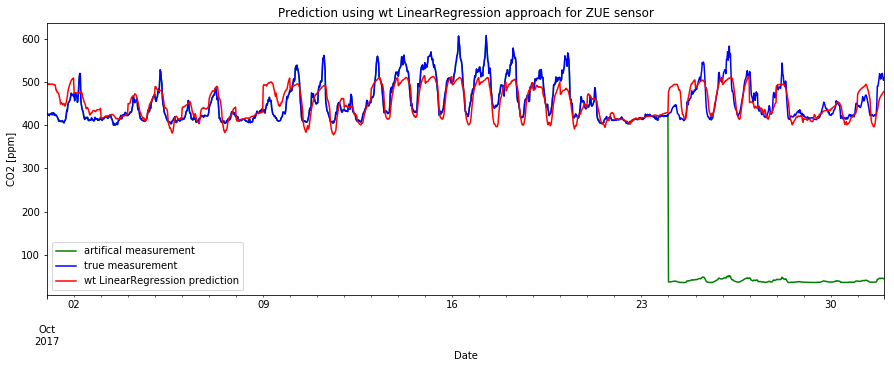

In [42]:
plot_prediction(df_complete, 'ZUE', 'wt', 'LinearRegression')

In [54]:
df_complete[df_complete['LocationName'] == 'ZUE']['wt_LinearRegression_prediction'].head()

timestamp
2017-10-01 00:00:00    496.270369
2017-10-01 00:30:00    494.737938
2017-10-01 01:00:00    494.139540
2017-10-01 01:30:00    495.644383
2017-10-01 02:00:00    494.578590
Name: wt_LinearRegression_prediction, dtype: float64

In [55]:
df_complete[df_complete['LocationName'] == 'AJGR']['naive_LinearRegression_prediction'].head()

timestamp
2017-10-01 00:00:00    344.868450
2017-10-01 00:30:00    344.860342
2017-10-01 01:00:00    344.614816
2017-10-01 01:30:00    344.447220
2017-10-01 02:00:00    344.231349
Name: naive_LinearRegression_prediction, dtype: float64

In [71]:
df_complete.tail()

,LocationName,SensorUnit_ID,CO2,temperature,humidity,median CO2,altitude,altitude_cluster,groundtruth,naive_Ridge_prediction,...,time,wt_LinearRegression_prediction,wt_Ridge_prediction,wt_ElasticNet_prediction,wt_Lasso_prediction,wind_speed,brute_force_Ridge_prediction,brute_force_Lasso_prediction,brute_force_ElasticNet_prediction,brute_force_LinearRegression_prediction
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-10-31 23:30:00,ZFHB,1291,420.311299,1.890000,94.947698,391.755015,518.5,4,NaN,NaN,...,47,NaN,NaN,NaN,NaN,0.686667,NaN,NaN,NaN,NaN
2017-10-31 23:30:00,RCTZ,1292,552.212598,-0.440000,96.288564,451.003079,440.9,7,NaN,NaN,...,47,NaN,NaN,NaN,NaN,0.686667,NaN,NaN,NaN,NaN
2017-10-31 23:30:00,WRTW,1297,502.498423,-0.033333,94.645065,428.965858,451.4,7,NaN,NaN,...,47,NaN,NaN,NaN,NaN,0.686667,NaN,NaN,NaN,NaN
2017-10-31 23:30:00,ZSEF,1298,488.848420,2.888333,82.544846,450.194847,415.1,5,NaN,NaN,...,47,NaN,NaN,NaN,NaN,0.686667,NaN,NaN,NaN,NaN
2017-10-31 23:30:00,ZLDW,1299,471.881151,3.286667,81.910970,425.401803,405.9,5,NaN,NaN,...,47,NaN,NaN,NaN,NaN,0.686667,NaN,NaN,NaN,NaN


In [44]:
#plot_zoomed_prediction(df_complete, 'ZUE', 'wt', 'LinearRegression', 'ZUE_wt', ci=True)

### 4) Brute force with other techniques (ridge, elastic net, lasso)

Take everything into consideration without defining any particular cluster for wind or altitude.

## TODO parameters to tweak. For now we don't seem to see a significant difference

In [45]:
# add wind speed value to complete df
df_complete['wind_speed'] = ZU_aw['wind_speed']

In [47]:
brute_force(df_complete, faulty_sensors)

In [69]:
"""sensor = 'ZSTA'
approach = 'brute_force'
for reg in regs:
    plot_prediction(df_complete, sensor, approach, reg)
    plot_zoomed_prediction(df_complete, sensor, approach, reg)"""

"sensor = 'ZSTA'\napproach = 'brute_force'\nfor reg in regs:\n    plot_prediction(df_complete, sensor, approach, reg)\n    plot_zoomed_prediction(df_complete, sensor, approach, reg)"

In [49]:
regs = ['LinearRegression', 'Lasso', 'Ridge', 'ElasticNet']
reg = ['LinearRegression']
print_MSE(df_complete, faulty_sensors, ['wt'], regs)


AJGR sensor
-----------
*****
MSE for wt LinearRegression prediction: 21782.03
MSE for wt Lasso prediction: 21687.56
MSE for wt Ridge prediction: 21772.23
MSE for wt ElasticNet prediction: 21000.81

BSCR sensor
-----------
*****
MSE for wt LinearRegression prediction: 4511.09
MSE for wt Lasso prediction: 4501.25
MSE for wt Ridge prediction: 4511.04
MSE for wt ElasticNet prediction: 4487.97

ZSTA sensor
-----------
*****
MSE for wt LinearRegression prediction: 948.19
MSE for wt Lasso prediction: 947.33
MSE for wt Ridge prediction: 948.20
MSE for wt ElasticNet prediction: 945.02

ZUE sensor
-----------
*****
MSE for wt LinearRegression prediction: 620.86
MSE for wt Lasso prediction: 628.25
MSE for wt Ridge prediction: 620.85
MSE for wt ElasticNet prediction: 628.05

ZSBN sensor
-----------
*****
MSE for wt LinearRegression prediction: 13550.53
MSE for wt Lasso prediction: 13510.84
MSE for wt Ridge prediction: 13549.96
MSE for wt ElasticNet prediction: 13500.55

ZLMT sensor
-----------
*

### Plots for presentation

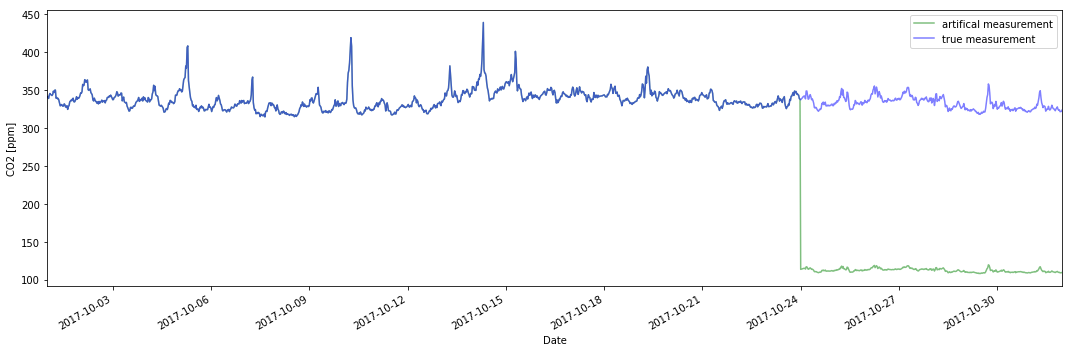

In [50]:
plot_example_faulty_sensor()

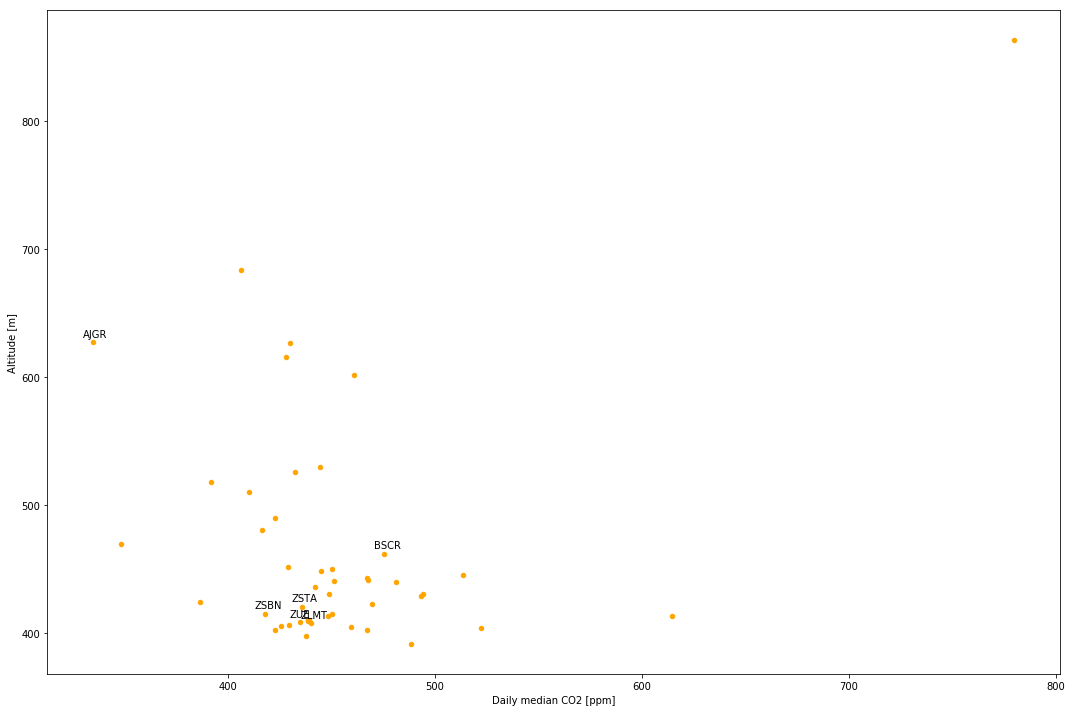

In [53]:
plot_altitude_cluster_features()

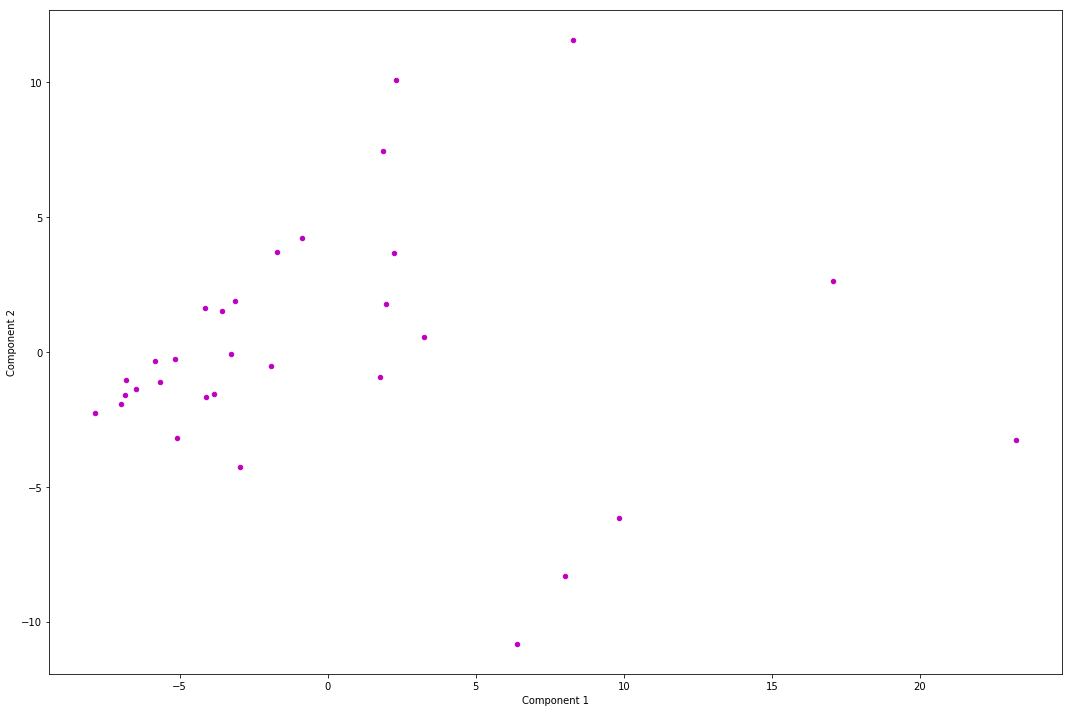

In [52]:
plot_wind_cluster_features()

## Bonus

Here is additional material that will help complete answers or clarifiy some questions asked during the public defense.

- what is your model ?
- how does the clustering look like ? For ZA and WT approaches.
- give further explanation about wind cluster features viz